In [1]:
import geopandas as gpd
from pathlib import Path
import warnings
import pandas as pd
import geonetworkx as gnx
import numpy as np

warnings.filterwarnings("ignore")

In [2]:
# read in the flow direction file
pts_fn = "/tiger1/pdas47/resorr-swot/data/cumberland_rivreg/cumberland_rivreg_pts.geojson"
edges_fn = "/tiger1/pdas47/resorr-swot/data/cumberland_rivreg/cumberland_rivreg.geojson"

In [3]:
G = gnx.read_geofiles(nodes_file_path=pts_fn, edges_file_path=edges_fn, directed=True)
G.remove_node(7)
G

In [4]:
NODE = 8
STATS_FN = Path('/tiger1/pdas47/resorr-swot/results/resorr-swot-stats/first-available.csv')
FIG_DIR = Path('/tiger1/pdas47/resorr-swot/results/time-series-figures/')

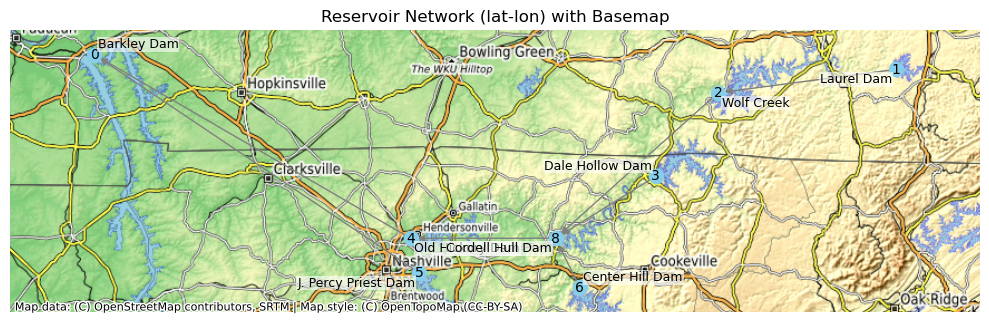

In [36]:
# plot the geonetwork (G) respecting the lat-lon values, with a basemap
import networkx as nx
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd

fig, ax = plt.subplots(figsize=(10, 8))
# Plot basemap (no zorder here)
nodes_gdf_web.plot(ax=ax, color='skyblue', markersize=100)
nx.draw(
    G,
    pos=pos_web,
    ax=ax,
    with_labels=True,
    node_size=100,
    node_color='skyblue',
    edge_color='gray',
    font_size=10,
)

# Offset node names to avoid overlap
for i, row in enumerate(nodes_gdf_web.itertuples()):
    dx = 2000 if i % 2 == 0 else -2000
    dy = 2000 if i % 3 == 0 else -2000
    ax.text(
        row.geometry.x + dx, row.geometry.y + dy,
        row.name,
        fontsize=9,
        ha='left' if dx > 0 else 'right',
        va='bottom' if dy > 0 else 'top',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.5),
        zorder=4
    )

ctx.add_basemap(ax, crs=nodes_gdf_web.crs, source=ctx.providers.OpenTopoMap)
ax.set_axis_off()
ax.set_title('Reservoir Network (lat-lon) with Basemap')
plt.tight_layout()
plt.show()

In [37]:
from resorr.network import ReservoirNetwork
from resorr.data_prep import _rat_read_inflow, calculate_volumes, aggregate
import xarray as xr

This is how the dataset should look like.

```Python
<xarray.Dataset>
Dimensions:                     (time: 3189, node: 8)
Coordinates:
  * time                        (time) datetime64[ns] 2013-01-21 ... 2021-10-14
  * node                        (node) int64 0 1 2 3 4 5 6 7
Data variables:
    theoretical_natural_runoff  (time, node) float64 27.2 6.046 ... nan nan
    storage_change              (time, node) float64 nan nan nan ... nan nan nan
    dt                          (time) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
```

In [38]:
inflow_dir = Path("/tiger1/pdas47/resorr-swot/data/tennesse/basins/cumberland/final_outputs/inflow")
storage_dir = Path("/tiger1/pdas47/resorr-swot/data/storage/swot_karin")
rat_output_level = 'final_outputs'

datasets_to_join = []
for node_id in G:
    node = G.nodes[node_id]
    name = node['name']
    print(f'{node_id}: {name}')
    # unregulated inflow
    unregulated_inflow_fn = inflow_dir / f"{name}.csv"

    if not unregulated_inflow_fn.exists():
        print(f"Missing {node_id} : {unregulated_inflow_fn}")
        continue
    unregulated_inflow = _rat_read_inflow(
        unregulated_inflow_fn, node_id, rat_output_level=rat_output_level)
    unregulated_inflow = unregulated_inflow.assign_coords(name=(["node"], [name]))
    datasets_to_join.append(unregulated_inflow)

    # storage change
    storage_fn = storage_dir / f"{node_id}.csv"
    # print(storage_fn)
    if storage_fn.exists():
        storage_df = pd.read_csv(storage_fn, parse_dates=['date'])
        storage_df['node'] = node_id
        storage_ds = storage_df.rename({'date': 'time'}, axis=1).set_index(['time', 'node']).to_xarray()
        datasets_to_join.append(storage_ds)

# datasets_to_join
rat_data = xr.merge(datasets_to_join)

0: Barkley_Dam
1: Laurel_Dam
2: Wolf_Creek
3: Dale_Hollow_Dam
4: Old_Hickory_Dam
5: J._Percy_Priest_Dam
6: Center_Hill_Dam
8: Cordell_Hull_Dam


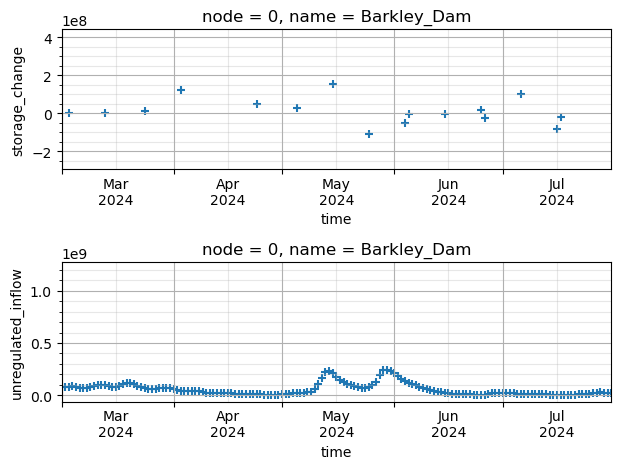

In [42]:
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from datetime import datetime
from matplotlib import ticker

f, ax = plt.subplots(nrows=2)


rat_data['storage_change'].sel(node=0).plot.scatter(
    x='time',
    y='storage_change',
    ax=ax[0], marker='+'
)

rat_data.sel(node=0).plot.scatter(
    x='time', y='unregulated_inflow', ax=ax[1], marker='+'
)

for axis in ax:
    axis.grid(which='major')
    axis.set_xlim([
        datetime(2024, 3, 1),
        datetime(2024, 7, 31),
    ])
    axis.xaxis.set_major_locator(mdates.MonthLocator())
    axis.xaxis.set_major_formatter(ticker.NullFormatter())
    axis.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
    axis.xaxis.set_minor_formatter(mdates.DateFormatter('%b\n%Y'))
    axis.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    axis.grid(which='minor', alpha=0.3)
    axis.tick_params(axis='x', labelrotation=0)
    axis.tick_params(axis='x', which='minor', tick1On=False, tick2On=False)
    # axis.set_ylim([-2e8, 0.5e8])
    for label in axis.get_xticklabels():
        label.set_horizontalalignment('center')

f.tight_layout()

In [ ]:
https://water.usace.army.mil/cda/reporting/providers/lrn/timeseries?name=BAHK2-BARKLEY.Flow.Ave.1Hour.1Hour.man-rev&begin=2024-01-01T00:00:00.000Z&end=2024-09-30T00:00:00.000Z&format=csv

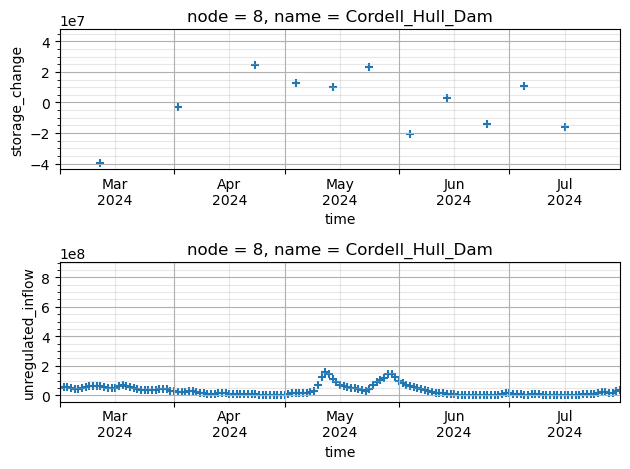

In [40]:
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from datetime import datetime
from matplotlib import ticker

f, ax = plt.subplots(nrows=2)


rat_data['storage_change'].sel(node=8).plot.scatter(
    x='time',
    y='storage_change',
    ax=ax[0], marker='+'
)

rat_data.sel(node=8).plot.scatter(
    x='time', y='unregulated_inflow', ax=ax[1], marker='+'
)

for axis in ax:
    axis.grid(which='major')
    axis.set_xlim([
        datetime(2024, 3, 1),
        datetime(2024, 7, 31),
    ])
    axis.xaxis.set_major_locator(mdates.MonthLocator())
    axis.xaxis.set_major_formatter(ticker.NullFormatter())
    axis.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
    axis.xaxis.set_minor_formatter(mdates.DateFormatter('%b\n%Y'))
    axis.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    axis.grid(which='minor', alpha=0.3)
    axis.tick_params(axis='x', labelrotation=0)
    axis.tick_params(axis='x', which='minor', tick1On=False, tick2On=False)
    # axis.set_ylim([-2e8, 0.5e8])
    for label in axis.get_xticklabels():
        label.set_horizontalalignment('center')

f.tight_layout()

In [12]:
rat_data
# # rat_data['storage_change_rate'] = rat_data['storage_change'] / rat_data['delta_t']

# ## aggregate volume to an time series split equally
# rat_data_aggregated = aggregate(rat_data, frequency='monthly', operations={'unregulated_inflow': np.mean, 'storage_change': np.sum})
# rat_data_aggregated
# # aggregated_volumes = calculate_volumes(rat_data_aggregated, fluxes=['unregulated_inflow'])
# # # aggregated_volumes = aggregated_volumes.rename({'storage_change': 'storage_change'})

# # # aggregated_volumes
# # forcings = xr.Dataset(
# #     data_vars={
# #         'theoretical_natural_runoff': aggregated_volumes['unregulated_inflow'],
# #         'storage_change': aggregated_volumes['storage_change'],
# #         'dt': aggregated_volumes['dt']
# #     }
# # )

# # forcings

<xarray.Dataset> Size: 622kB
Dimensions:             (time: 1897, node: 8)
Coordinates:
  * time                (time) datetime64[ns] 15kB 2020-05-06 ... 2025-07-15
  * node                (node) int64 64B 0 1 2 3 4 5 6 8
    name                (node) object 64B 'Barkley_Dam' ... 'Cordell_Hull_Dam'
Data variables:
    unregulated_inflow  (time, node) float64 121kB 27.15 6.033 ... 1.057e+07
    elevation           (time, node) float64 121kB nan nan nan ... nan nan nan
    storage             (time, node) float64 121kB nan nan nan ... nan nan nan
    storage_change      (time, node) float64 121kB nan nan nan ... nan nan nan
    delta_t             (time, node) float64 121kB nan nan nan ... nan nan nan

In [13]:
list(rat_data.data_vars.keys())

['unregulated_inflow', 'elevation', 'storage', 'storage_change', 'delta_t']

NameError: name 'aggregated_volumes' is not defined

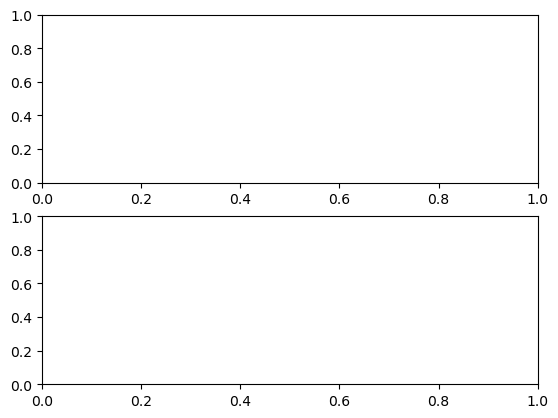

In [14]:
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from datetime import datetime
from matplotlib import ticker

f, ax = plt.subplots(nrows=2)


aggregated_volumes['storage_change'].sel(node=0).plot.scatter(
    x='time',
    y='storage_change',
    ax=ax[0], marker='+'
)

rat_data.sel(node=0).plot.scatter(
    x='time', y='storage_change', ax=ax[1], marker='+'
)

for axis in ax:
    axis.grid(which='major')
    axis.set_xlim([
        datetime(2024, 1, 1),
        datetime(2024, 3, 31),
    ])
    axis.xaxis.set_major_locator(mdates.MonthLocator())
    axis.xaxis.set_major_formatter(ticker.NullFormatter())
    axis.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
    axis.xaxis.set_minor_formatter(mdates.DateFormatter('%b\n%Y'))
    axis.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    axis.grid(which='minor', alpha=0.3)
    axis.tick_params(axis='x', labelrotation=0)
    axis.tick_params(axis='x', which='minor', tick1On=False, tick2On=False)
    axis.set_ylim([-2e8, 0.5e8])
    for label in axis.get_xticklabels():
        label.set_horizontalalignment('center')

f.tight_layout()

In [13]:
print(list(forcings.time))

[<xarray.DataArray 'time' ()> Size: 8B
array('2020-05-10T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2020-05-10, <xarray.DataArray 'time' ()> Size: 8B
array('2020-05-17T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2020-05-17, <xarray.DataArray 'time' ()> Size: 8B
array('2020-05-24T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2020-05-24, <xarray.DataArray 'time' ()> Size: 8B
array('2020-05-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2020-05-31, <xarray.DataArray 'time' ()> Size: 8B
array('2020-06-07T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2020-06-07, <xarray.DataArray 'time' ()> Size: 8B
array('2020-06-14T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2020-06-14, <xarray.DataArray 'time' ()> Size: 8B
array('2020-06-21T0

In [14]:
from tqdm.notebook import tqdm

start_time = pd.to_datetime('2023-08-27') # date from which weekly data is available. Change as per model dt.
end_time = pd.to_datetime('2025-06-30')
forcings = forcings.sel(time=slice(start_time, end_time))

reservoir_network = ReservoirNetwork(G, start_time)
print(reservoir_network)
for timestep in tqdm(forcings.time.values):
    # print(timestep)
    dt = forcings[['time', 'dt']].sel(time=timestep)['dt'].values.item()
    reservoir_network.update(forcings, dt, 'wb')

reservoir_network.data

ReservoirNetwork with 8 nodes and 7 edges


  0%|          | 0/97 [00:00<?, ?it/s]

<xarray.Dataset> Size: 51kB
Dimensions:                     (node: 8, time: 97)
Coordinates:
  * node                        (node) int64 64B 0 1 2 3 4 5 6 8
  * time                        (time) datetime64[ns] 776B 2023-08-27 ... 202...
Data variables:
    inflow                      (node, time) float64 6kB 2.148e+09 ... 1.35e+07
    outflow                     (node, time) float64 6kB 0.0 1.036e+09 ... 0.0
    regulated_runoff            (node, time) float64 6kB 1.876e+09 ... 0.0
    natural_runoff              (node, time) float64 6kB 2.72e+08 ... 1.35e+07
    theoretical_natural_runoff  (time, node) float64 6kB 4.677e+08 ... 1.009e+08
    storage                     (node, time) float64 6kB nan nan nan ... nan nan
    storage_change              (time, node) float64 6kB nan nan ... nan nan
    regulation                  (node, time) float64 6kB -1.681e+09 ... 8.739...
    dt                          (time) int64 776B 7 7 7 7 7 7 7 ... 7 7 7 7 7 7

In [15]:
import numpy as np

RESERVOIR = NODE

## COMPARE WITH in-situ INFLOW
# read the bounding box of the study area
RESERVOIRS_GDF = gpd.read_file(Path('/tiger1/pdas47/resorr-swot/data/cumberland-reservoirs/03-cumberland-reservoirs.geojson'))

res_names = RESERVOIRS_GDF[['id', 'name']].set_index('id').to_dict()['name'] # dictionary that can be queried to get reservoir name

RESERVOIR_NAME = res_names[RESERVOIR]

RESERVOIR_GDF = RESERVOIRS_GDF.loc[RESERVOIRS_GDF['id'] == RESERVOIR]

# get reservoir properties from GRanD
nominal_area = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_SKM'].values[0]
nominal_area_poly = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_POLY'].values[0]
max_area = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_MAX'].values[0]
max_area = np.nan if max_area == -99 else max_area

min_area = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_MIN'].values[0]
min_area = 0 if min_area == -99 else min_area

area_rep = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_REP'].values[0]
dam_height = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['DAM_HGT_M'].values[0])
elev_msl = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['ELEV_MASL'].values[0])
depth = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['DEPTH_M'].values[0])
capacity = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['CAP_MCM'].values[0])

print(RESERVOIR_NAME)

Cordell_Hull_Dam


In [16]:
def get_insitu_observed_data(
        id, 
        RESERVOIRS_GDF, 
        src_dir = Path('/tiger1/pdas47/resorr-swot/data/insitu/resops')
    ):
    row = RESERVOIRS_GDF[RESERVOIRS_GDF['id'] == id]
    name = row['name'].values[0]
    src_dir = Path(src_dir)
    src = src_dir.name

    if src == 'resops':
        src_fn = src_dir / f'{name}.csv'
        insitu_df = pd.read_csv(src_fn)
    elif src =='usace':
        name_without_dam = name.replace('_Dam', '')
        elevation_src_fn = src_dir / f'{name_without_dam}-elevation'
        inflow_src_fn = src_dir / f'{name_without_dam}-inflow'
        outflow_src_fn = src_dir / f'{name_without_dam}-outflow'
        storage_src_fn = src_dir / f'{name_without_dam}-storage'

        elevation_df = pd.read_csv(elevation_src_fn, comment='#', names=['time', 'elevation'], index_col=0)
        elevation_df.index = pd.to_datetime(elevation_df.index)
        inflow_df = pd.read_csv(inflow_src_fn, comment='#', names=['time', 'inflow'], index_col=0)
        inflow_df.index = pd.to_datetime(inflow_df.index)
        outflow_df = pd.read_csv(outflow_src_fn, comment='#', names=['time', 'outflow'], index_col=0)
        outflow_df.index = pd.to_datetime(outflow_df.index)
        storage_df = pd.read_csv(storage_src_fn, comment='#', names=['time', 'storage'], index_col=0)
        storage_df.index = pd.to_datetime(storage_df.index)

        insitu_df = pd.concat([elevation_df, inflow_df, outflow_df, storage_df], axis=1)
        # insitu data is in hourly time format
        insitu_df = insitu_df.resample('1D').median()
        # convert from imperial to SI
        insitu_df['elevation'] = insitu_df['elevation'] * 0.3048
        insitu_df['inflow'] = insitu_df['inflow'] * 0.028316847
        insitu_df['outflow'] = insitu_df['outflow'] * 0.028316847
        insitu_df['storage'] = insitu_df['storage'] * 1233.48


    return insitu_df


observed_df = get_insitu_observed_data(RESERVOIR, RESERVOIRS_GDF, '/tiger1/pdas47/resorr-swot/data/insitu/usace')
observed_df

,elevation,inflow,outflow,storage
time,,,,
2019-01-01 00:00:00+00:00,153.310,1634.355024,NaN,3.049341e+08
2019-01-02 00:00:00+00:00,153.500,1077.430016,NaN,3.139143e+08
2019-01-03 00:00:00+00:00,152.745,763.335011,NaN,2.795149e+08
2019-01-04 00:00:00+00:00,152.350,812.115012,NaN,2.629543e+08
2019-01-05 00:00:00+00:00,152.395,1087.265016,NaN,2.647661e+08
...,...,...,...,...
2025-06-17 00:00:00+00:00,153.645,330.340005,241.965003,3.208183e+08
2025-06-18 00:00:00+00:00,153.735,651.435009,750.750011,3.252351e+08
2025-06-19 00:00:00+00:00,153.540,742.045011,834.070012,3.158164e+08


In [ ]:
observed_aggregated = calculate_volumes(
    aggregate(observed_df.to_xarray(), 'weekly'),
    ['inflow', 'outflow']
).to_pandas()
observed_aggregated['inflow'] = observed_aggregated['inflow']*1e6 # m3
observed_aggregated['outflow'] = observed_aggregated['outflow']*1e6 # m3
observed_aggregated = observed_aggregated[
    (observed_aggregated.index>'2023-07-30')
]
observed_aggregated

,elevation,inflow,outflow,storage,dt
time,,,,,
2023-08-06 00:00:00+00:00,153.675000,1.547515e+09,9.062900e+08,3.224015e+08,7
2023-08-13 00:00:00+00:00,153.627143,1.671395e+09,9.075550e+08,3.200612e+08,7
2023-08-20 00:00:00+00:00,153.591429,1.602845e+09,1.144135e+09,3.182712e+08,7
2023-08-27 00:00:00+00:00,153.632143,2.084005e+09,1.936305e+09,3.203310e+08,7
2023-09-03 00:00:00+00:00,153.640000,1.908910e+09,2.244260e+09,3.206844e+08,7
...,...,...,...,...,...
2025-05-25 00:00:00+00:00,153.630714,5.344520e+09,5.593285e+09,3.202335e+08,7
2025-06-01 00:00:00+00:00,153.679286,5.590320e+09,5.461750e+09,3.225908e+08,7
2025-06-08 00:00:00+00:00,153.588571,2.180565e+09,2.168615e+09,3.182041e+08,7


In [18]:
resorr_out = reservoir_network.data.sel(node=NODE).to_pandas()

# Convert to datetime64[ns]
time_index = observed_aggregated.index

# Explicitly set the timezone to UTC
time_index_naive = time_index.tz_localize(None)

observed_aggregated.index = time_index_naive

df_for_comparison = pd.concat(
    [
        observed_aggregated['inflow'].rename('observed_inflow'), 
        resorr_out['inflow'].rename('resorr_inflow'), 
        resorr_out['theoretical_natural_runoff']
    ], axis=1
)

df_for_comparison = df_for_comparison*1e-6 # mil. m3

In [19]:
df_for_comparison

,observed_inflow,resorr_inflow,theoretical_natural_runoff
time,,,
2023-08-06,1547.515022,NaN,NaN
2023-08-13,1671.395024,NaN,NaN
2023-08-20,1602.845023,NaN,NaN
2023-08-27,2084.005030,2183.482884,140.534297
2023-09-03,1908.910028,12.270225,72.468751
...,...,...,...
2025-06-01,5590.320081,25.849600,310.199889
2025-06-08,2180.565031,2201.050881,191.412055
2025-06-15,2624.870038,1099.632940,179.820817


Text(0.5, 1.0, 'Cordell Hull Dam')

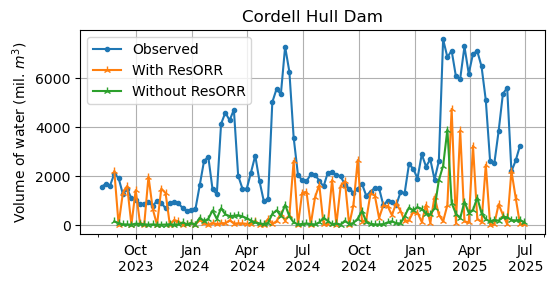

In [20]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

f, ax = plt.subplots(figsize=(6,3))

name = G.nodes[NODE]['name']
plt.plot(
    df_for_comparison.index,
    df_for_comparison.observed_inflow,
    marker='.',
    label='Observed'
)
plt.plot(
    df_for_comparison.index,
    df_for_comparison.resorr_inflow,
    marker='2',
    label='With ResORR'
)
plt.plot(
    df_for_comparison.index,
    df_for_comparison.theoretical_natural_runoff,
    marker='2',
    label='Without ResORR'
)
# ax.set_yscale('log')
plt.legend()
plt.grid()
date_form = mdates.DateFormatter('%Y-%m') # Example: YYYY-MM-DD
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(10, 1, 4, 7))) # First month of each water quarter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y')) # Quarter and Year
ax.xaxis.set_minor_locator(mdates.MonthLocator()) # First month of each water quarter
# ax.xaxis.set_minor_formatter(mdates.DateFormatter()) # Quarter and Year

f.autofmt_xdate(ha='center', rotation=0)
ax.set_ylabel('Volume of water (mil. $m^3$)')
ax.set_title(f'{name.replace("_", " ")}')

In [21]:
f.savefig(
    FIG_DIR / f'weekly-{name}.png',
    dpi=900,
)

In [22]:
# calculate statistics
import HydroErr as he

with_resorr_stats = [
    fn(df_for_comparison['resorr_inflow'], df_for_comparison['observed_inflow'])
    for fn in (he.nse, he.mae, he.rmse, he.kge_2012, he.r_squared, he.spearman_r)
]
without_resorr_stats = [
    fn(df_for_comparison['theoretical_natural_runoff'], df_for_comparison['observed_inflow'])
    for fn in (he.nse, he.mae, he.rmse, he.kge_2012, he.r_squared, he.spearman_r)
]

zipped_stats = list(zip(with_resorr_stats, without_resorr_stats))

stats_df = pd.DataFrame({
    'reservoir_id': [NODE, NODE],
    'reservoir_name': [name, name],
    'with_or_without_resorr': ['with resorr', 'without resorr'],
    'NSE': zipped_stats[0],
    'MAE': zipped_stats[1],
    'RMSE': zipped_stats[2],
    'KGE': zipped_stats[3],
    'rsquared': zipped_stats[4],
    'spearman_r': zipped_stats[5]
})
stats_df_long = pd.melt(
    stats_df, 
    id_vars=['reservoir_id', 'with_or_without_resorr', 'reservoir_name'], 
    value_vars=['NSE', 'MAE', 'RMSE', 'KGE', 'rsquared', 'spearman_r'], 
    var_name='metric', 
    value_name='metric_value'
)
stats_df_long

,reservoir_id,with_or_without_resorr,reservoir_name,metric,metric_value
0,8,with resorr,Cordell_Hull_Dam,NSE,-1.101349
1,8,without resorr,Cordell_Hull_Dam,NSE,-1.168901
2,8,with resorr,Cordell_Hull_Dam,MAE,2084.681007
3,8,without resorr,Cordell_Hull_Dam,MAE,2330.489587
4,8,with resorr,Cordell_Hull_Dam,RMSE,2853.016260
5,8,without resorr,Cordell_Hull_Dam,RMSE,2898.511124
6,8,with resorr,Cordell_Hull_Dam,KGE,-0.433717
7,8,without resorr,Cordell_Hull_Dam,KGE,-0.547977
8,8,with resorr,Cordell_Hull_Dam,rsquared,0.022718
9,8,without resorr,Cordell_Hull_Dam,rsquared,0.330142


In [23]:
HEADER = False if STATS_FN.exists() else True
stats_df_long.to_csv(
    STATS_FN,
    mode='a',
    header=HEADER,
    index=False
)